# Technical Report- ADC Part 3

## Methods

Similar to Part 2- we are using a function waveform generator, a sine wave at 10Hz frequency and $V_{pp} = 2V$ was generated into the board. 20 cycles of this wave were sampled (~2s of sampling) and documented using a calc_cycles function. Additionally, a hex dump was also collected which contains all of the sampling data.

In this experiment, the hex dump data was unwrapped into two's compliment, which were then converted using the digital output equation below:

$$
\text{RESULT} = V_{\text{DIFFERENCE}} \times \frac{\text{GAIN}}{\text{REFERENCE}} \times 2^{\text{RESOLUTION} - m}
$$

and $V_{\text{DIFFERENCE}}$ was solved for in order to find the two's compliment values in terms of the voltage difference.

Below, we also have to determine the frequency of the acquired sine wave to ensure it close to 10Hz to validate that the input frequency is the same/similar to the sampled signal.

We need to verify that, even though we are using asynchronous sampling, we still achieve the same/similar results as in the synchronous sampling. This time, however, we need to discuss the differences (pros and cons) between synchronous and asynchronous sampling and this will be done in the discussion.

## Unwrap and Plot Hex Data

In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# `hexdump.txt`` was copied from `LOG_HEXDUMP` terminal output
# we know this is a hexdump of int16 values storing 12-bit data
from bme554 import read_hex_data

hex_data = read_hex_data('hexdump_part3.txt')

print(f'Raw Bytes of Data: {hex_data}')

Raw Bytes of Data: ['d7', '01', '24', '02', '60', '02', '94', '02', 'b5', '02', 'c4', '02', 'c1', '02', 'ac', '02', '89', '02', '55', '02', '14', '02', 'c4', '01', '6c', '01', '05', '01', '97', '00', '2a', '00', 'bf', 'ff', '53', 'ff', 'e7', 'fe', '88', 'fe', '2d', 'fe', 'e6', 'fd', 'a5', 'fd', '78', 'fd', '55', 'fd', '4a', 'fd', '48', 'fd', '5b', 'fd', '80', 'fd', 'b4', 'fd', 'f8', 'fd', '43', 'fe', 'a4', 'fe', '03', 'ff', '6d', 'ff', 'dc', 'ff', '4b', '00', 'b7', '00', '22', '01', '84', '01', 'dc', '01', '27', '02', '67', '02', '96', '02', 'b5', '02', 'c7', '02', 'c2', '02', 'aa', '02', '85', '02', '55', '02', '0e', '02', 'c0', '01', '68', '01', '00', '01', '95', '00', '28', '00', 'bb', 'ff', '4e', 'ff', 'e8', 'fe', '86', 'fe', '28', 'fe', 'e1', 'fd', 'a1', 'fd', '6f', 'fd', '51', 'fd', '48', 'fd', '48', 'fd', '5e', 'fd', '81', 'fd', 'b6', 'fd', 'fa', 'fd', '4b', 'fe', 'a5', 'fe', '0b', 'ff', '71', 'ff', 'e4', 'ff', '50', '00', 'bf', '00', '25', '01', '8a', '01', 'dd', '01', '27', '0

Text(0.5, 1.0, 'Extracted Raw Voltage Data from Hexdata Dump')

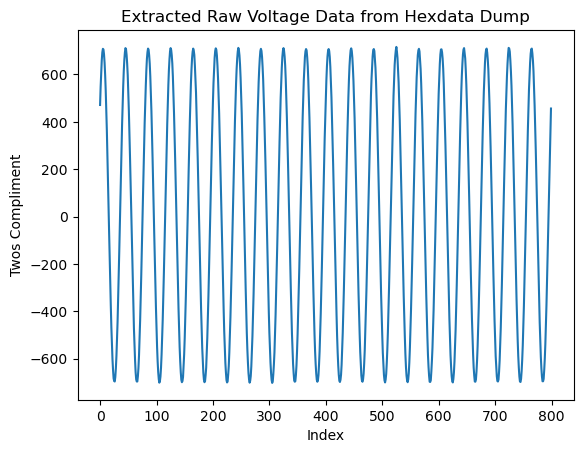

In [15]:
#now we will plot the data
from bme554 import unwrap_twos_complement
raw_voltage = unwrap_twos_complement(hex_data)

plt.plot(raw_voltage)
plt.xlabel('Index')
plt.ylabel('Twos Compliment')
plt.title('Extracted Raw Voltage Data from Hexdata Dump')
#look at the y-axis- it is in terms of two's compliment instead of volts

Text(0.5, 1.0, 'Extracted Raw Voltage Data from Hexdata Dump (in volts)')

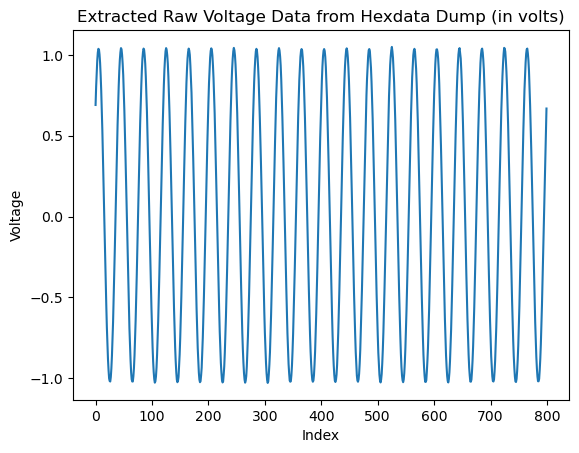

In [16]:
#now we will plot using the voltage using this equation
twos = np.asarray(raw_voltage, dtype = float)

GAIN = 1/5
REF = .6
res = 12
volts = (twos * REF)/ ((GAIN)*2**(res-1))

plt.plot(volts)
plt.xlabel('Index')
plt.ylabel('Voltage')
plt.title('Extracted Raw Voltage Data from Hexdata Dump (in volts)')
#note the range of the y-axis is from [-1,1] which is what we expect given V_pp = 2.0V

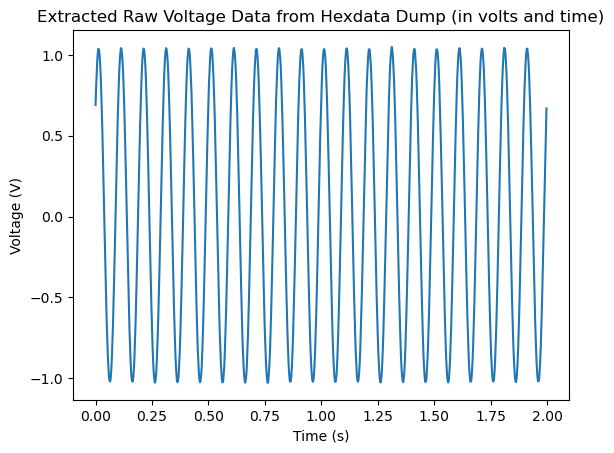

In [17]:
#converting indices in terms of time
fs = 400
time = np.arange(len(volts)) / fs
plt.plot(time, volts)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Extracted Raw Voltage Data from Hexdata Dump (in volts and time)')
plt.show()


## Finding Zero Crossings to Determine Frequency

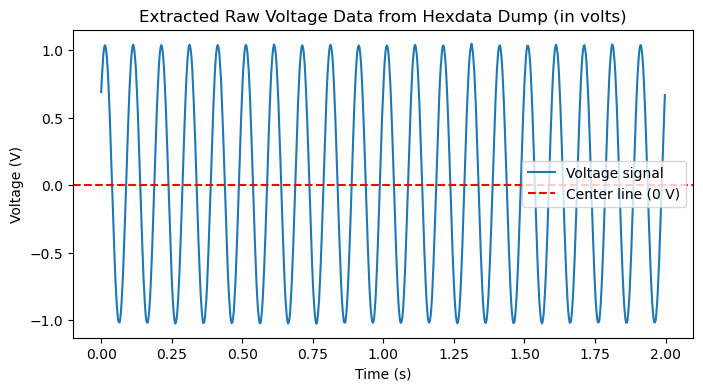

Zero crossing times (in s):
[0.03848131 0.08831081 0.13841743 0.18814815 0.23828829 0.28816372
 0.33813679 0.38802966 0.43809735 0.4879386  0.53801802 0.58776786
 0.63788288 0.68775229 0.73783482 0.78761161 0.8377193  0.88745575
 0.93756696 0.98743119 1.03752232 1.08733796 1.13740826 1.18722727
 1.23731651 1.28711009 1.33713964 1.38695175 1.43713636 1.48692661
 1.53697248 1.58688073 1.63690265 1.68674779 1.73676339 1.78662162
 1.83666667 1.88648148 1.93657895 1.98636957]


In [18]:
#our sampling rate
fs = 400  


twos = np.asarray(raw_voltage, dtype=float)
GAIN = 1/5
REF = 0.6
res = 12
volts = (twos * REF) / (GAIN * 2**(res - 1))

#Create time array
time = np.arange(len(volts)) / fs

#plotting graph
plt.figure(figsize=(8,4))
plt.plot(time, volts, label='Voltage signal')
plt.axhline(0, color='red', linestyle='--', label='Center line (0 V)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Extracted Raw Voltage Data from Hexdata Dump (in volts)')
plt.legend()
plt.show()

#Find zero crossings
zero_crossings_idx = np.where(np.diff(np.sign(volts)))[0]

#Interpolate to get more precise zero-crossing indices
zero_crossings_idx_interp = zero_crossings_idx - volts[zero_crossings_idx] / (
    volts[zero_crossings_idx + 1] - volts[zero_crossings_idx]
)

# Convert zero-crossing indices to time
zero_crossings_time = zero_crossings_idx_interp / fs

print("Zero crossing times (in s):")
print(zero_crossings_time)



Now that we have our zero crossings calculated we must determine the frequency. We can do this by taking two data points that are separated by one other data point (i.e. every other point) as we have to capture an entire period. We will take the 3rd and 5th points (as our first cycle is incomplete due to arbitrary sampling):

$$ |0.08831081 - 0.18814815| = 0.09983734$$
$$ \text{frequency} = \frac{1}{0.09983734} = 10.02 \approx \fbox {10 Hz}$$

## Discussion

In this section of the lab, we used a function waveform generator to input a sine wave at 10Hz frequency and $V_{pp} = 2V$ for our asynchronous sampling. This was then recorded using logging statements and a hexdump to generate the sampling data. We unwrapped the hexdump into two's compliment and used a digital output equation to plot it in terms of volts vs. time. Note that we also calcualted the frequency of the generated sine wave and received a resullt of around 10Hz which is the same value we input into the board. This indicates that our sampled signal and the input frequency are consistent.

The functionality is the same as in part 2, which is what we were expecting. In comparision to the previous part, it can be also observed that the logging statements and hex dump are generated qualitatively quicker. Since adc_read_async is non-blocking, this allows for more important tasks to take place (i.e. heartbeat and hexdump).  The board can perform other operations while ADC is collecting the samples in the background. However, it is more complex due to the addition of a callback function, which allows more likelihood for error and bugs to occur.